# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

### Preliminary step: Install and Import Libraries.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import IPython
import torch
import torchaudio
import os
import tqdm
import museval  #se non funziona con versioni di Python >= 3.10, si deve cambiare un tipo di dato in un funzione che chiama. Basta seguire quello che dice l'errore
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.transforms import Fade


### Load the Model

In [3]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

### Load the Dataset

Download the dataset at: https://zenodo.org/records/3338373

In [4]:
# Load dataset and choose the length of the tracks for each song (in seconds)
DATASET_FOLDER =  "./musdb18hq/test"
SEGMENT = 30  # We'll keep exactly 30 seconds from each track


track_folders = sorted(
    folder for folder in os.listdir(DATASET_FOLDER)
    if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
)

# Dictionary to store {track_folder -> {stem_name -> waveform}}
dataset_dict = {}


# Each subfolder in musdb18hq/test corresponds to a track
for track_folder in track_folders:
    track_path = os.path.join(DATASET_FOLDER, track_folder)
    if not os.path.isdir(track_path):
        continue

    # Prepare a sub-dictionary for this track
    stems_dict = {}
    stem_names = ["mixture", "drums", "bass", "vocals", "other"]
    
    for stem_name in stem_names:
        file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
        
        if not os.path.isfile(file_path):
            print(f"Warning: file not found {file_path}")
            continue

        # Load full audio
        print(f"Loading {file_path}...")
        waveform, sr = torchaudio.load(file_path)
        
        # Keep only the first 30s
        segment_samples = SEGMENT * sr
        waveform_segment = waveform[:, :segment_samples]

        stems_dict[stem_name] = waveform_segment

    dataset_dict[track_folder] = stems_dict

print("Loaded tracks:", list(dataset_dict.keys()))

Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/mixture.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/drums.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/bass.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/vocals.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/other.wav...
Loading /Users/filippo/Library/CloudSt

In [5]:
def find_non_silent_segment(stems: dict, segment_seconds: float, sample_rate: int, energy_threshold: float = 1e-4):
    """
    Finds a contiguous segment of seconds (segment_seconds) where every stem has non-silent audio.
    A segment is considered non-silent if for each stem the sum of the absolute amplitudes in each channel
    is greater than energy_threshold.

    Args:
        stems (dict): Dictionary mapping stem_name to waveform tensor of shape (channels, samples).
        segment_seconds (float): Desired segment duration in seconds.
        sample_rate (int): Sample rate to compute the segment length.
        energy_threshold (float): Minimal energy required per channel in the segment.
    
    Returns:
        dict or None: Dictionary with the same keys as stems but only containing the non-silent segment,
                      or None if no such segment is found.
    """
    segment_samples = int(segment_seconds * sample_rate)
    
    # use the first stem to determine the total length
    total_samples = next(iter(stems.values())).shape[1]
    
    # use a reasonable step to speed up search (e.g., 10% of segment_samples)
    step = max(1, segment_samples // 10)
    
    for start in range(0, total_samples - segment_samples + 1, step):
        valid = True
        # Check every stem for non-silence on all channels
        for waveform in stems.values():
            segment = waveform[:, start:start+segment_samples]
            energy = segment.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                valid = False
                break
        if valid:
            # If found, return a new dictionary with the non-silent segment for each stem.
            return {stem: waveform[:, start:start+segment_samples] for stem, waveform in stems.items()}
        
    return None

### Processing a Single Track

#### Choose a Track to Process
Try analyze different tracks by changing the index of ***track_names[index]***

In [6]:
# Now you have a dictionary with track_folder as the key,
# and a sub-dict with "mixture", "drums", "bass", "vocals", "other" waveforms
track_names = list(dataset_dict.keys())

track_chosen = track_names[25]
print("Chosen track name:", track_chosen)

stems_available = list(dataset_dict[track_chosen].keys())
print("Stems:", stems_available)  # e.g. ['mixture', 'drums', 'bass', 'vocals', 'other']

# Check duration
mixture_waveform = dataset_dict[track_chosen]["mixture"]
duration_seconds = mixture_waveform.shape[1] / sample_rate
print(f"Duration (seconds): {duration_seconds}")

# Ensure we have all 5 stems
if len(stems_available) < 5:
    print("Warning: Not all stems found. This track might be incomplete.")

Chosen track name: Mu - Too Bright
Stems: ['mixture', 'drums', 'bass', 'vocals', 'other']
Duration (seconds): 30.0


#### Prepare the Data for Separation

In [7]:
mixture_waveform = mixture_waveform.to(device)

In [8]:
def normalize_waveform(mixture_waveform: torch.Tensor, device: torch.device) -> torch.Tensor:
    """
    Normalize a waveform by moving it to the specified device, 
    and ensuring zero mean and unit variance across channels.

    Args:
        mixture_waveform (torch.Tensor): The input waveform tensor.
        device (torch.device): The device to move the waveform to.

    Returns:
        torch.Tensor: The normalized waveform.
        ref (torch.Tensor): The reference tensor used for normalization.
    """
    # Move waveform to the specified device
    mixture_waveform = mixture_waveform.to(device)

    # Normalization across the channels
    ref = mixture_waveform.mean(0)  # (2, samples) -> (samples,)

    # Signal with zero mean and unit variance
    mixture_norm = (mixture_waveform - ref.mean()) / ref.std()

    return mixture_norm, ref

In [9]:
# Normalize the mixture waveform and get the reference tensor
mixture_norm, ref = normalize_waveform(mixture_waveform, device)

In [10]:
def invert_normalization(normalized_waveform: torch.Tensor, reference: torch.Tensor) -> torch.Tensor:
    """
    Inverts the normalization on a waveform.
    Assumes normalization was done as:
       normalized = (waveform - reference.mean()) / reference.std()
       
    Args:
        normalized_waveform (torch.Tensor): The normalized waveform.
        reference (torch.Tensor): The original waveform used to compute normalization statistics.
        
    Returns:
        torch.Tensor: The waveform with the original scale restored.
    """
    return normalized_waveform * reference.std() + reference.mean()

In [11]:
def separate_sources(
    model,
    mix,
    segment=30,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # chunk_len for entire 30s, no overlap
    chunk_len = int(sample_rate * segment * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

#### Run Separation

In [12]:
print("Separating 30-second track with no overlap...")
import os

# Enable MPS fallback for unsupported operations
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Ensure both the model and the input tensor are on the same device
model.to("cpu")
mixture_norm_cpu = mixture_norm[None].to("cpu")  # Move input tensor to CPU

sources_tensor = separate_sources(
    model,
    mixture_norm_cpu,  # Use the tensor on the CPU
    segment=30,
    overlap=0.0,
    device="cpu"  # Use CPU for this operation
)[0].to(device)  # Move back to MPS after the operation

# Move the model back to the original device (MPS)
model.to(device)

# Undo normalization
sources_tensor = sources_tensor * ref.std() + ref.mean()

# Build a dict {stem_name -> predicted_stem}
stem_names = model.sources  # ['drums', 'bass', 'other', 'vocals'] typically
predicted_stems = dict(zip(stem_names, list(sources_tensor)))


Separating 30-second track with no overlap...


#### Evaluations

In [13]:
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str, getOutput=False):
    # Move to CPU
    original_np = original_source.detach().cpu().numpy()
    predicted_np = predicted_source.detach().cpu().numpy()

    # If shape is (C, T), that's fine for mir_eval if C=2
    # but let's ensure it's (2, T) not (T, 2)
    # Usually PyTorch waveforms are (channels, samples),
    # which is correct for bss_eval_sources.

    # Verify the energy of the reference(sum of the absolutes for each channel).
    energy = original_source.abs().sum(dim=1)
    print(f"{source} - Energy per channel: {energy}")
    
    # If one of the cheannel has an energy below the energy threshold (1e-3), skip the evaluation
    if (energy < 1e-3).any():
        print(f"Warning: {source} reference appears silent or nearly silent. Skipping evaluation for this stem.")
        return None  # oppure ritorna un valore di default o una stringa informativa
    sdr, sir, sar, _ = separation.bss_eval_sources(
        reference_sources=original_np,
        estimated_sources=predicted_np
    )

    print(f"--- {source} ---")
    print("SDR:", sdr.mean())
    print("SIR:", sir.mean())
    print("SAR:", sar.mean())
    print("----------------")

    if getOutput:
        return Audio(predicted_source.cpu(), rate=sample_rate)

# Retrieve references from dataset_dict
drums_ref = dataset_dict[track_chosen]["drums"].to(device)
bass_ref = dataset_dict[track_chosen]["bass"].to(device)
vocals_ref = dataset_dict[track_chosen]["vocals"].to(device)
other_ref = dataset_dict[track_chosen]["other"].to(device)

# Predicted
drums_pred = predicted_stems["drums"]
bass_pred  = predicted_stems["bass"]
vocals_pred = predicted_stems["vocals"]
other_pred = predicted_stems["other"]

# Evaluate each stem
output_results(drums_ref, drums_pred, "Drums")
output_results(bass_ref, bass_pred, "Bass")
output_results(vocals_ref, vocals_pred, "Vocals")
output_results(other_ref, other_pred, "Other")

Drums - Energy per channel: tensor([33873.6250, 37868.5703], device='mps:0')


/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_45537/265406633.py:19: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(


--- Drums ---
SDR: 18.217174566513556
SIR: 32.395181868754605
SAR: 18.390333566457947
----------------
Bass - Energy per channel: tensor([12980.2188, 12790.1113], device='mps:0')
--- Bass ---
SDR: 11.210318517719578
SIR: 33.54281600122741
SAR: 11.23787602306246
----------------
Vocals - Energy per channel: tensor([25457.0078, 25799.2461], device='mps:0')
--- Vocals ---
SDR: 13.662620232887914
SIR: 31.7564004116576
SAR: 13.733936897451358
----------------
Other - Energy per channel: tensor([29620.5078, 28936.1367], device='mps:0')
--- Other ---
SDR: 9.428652091420789
SIR: 31.41757293316304
SAR: 9.461064094425627
----------------


## Analyze SDR / gains 

In [14]:
def create_new_mixture(track_name: str, gains: torch.Tensor, dataset_dict: dict) -> torch.Tensor:
    """
    Create a new mixture for a given track name and desired gains.

    Args:
        track_name (str): The name of the track to process.
        gains (torch.Tensor): Tensor containing the gain values for each stem.
        dataset_dict (dict): Dictionary containing the dataset with track stems.

    Returns:
        torch.Tensor: The newly generated mixture waveform.
    """
    if track_name not in dataset_dict:
        raise ValueError(f"Track '{track_name}' not found in the dataset_dict.")

    # Retrieve the original stems for the given track
    original_stems = dataset_dict[track_name]

    # Normalize the gains
    gains_normalized = gains / gains.sum()
    # Ensure gains are on the same device as the stems
    device = next(iter(original_stems.values())).device
    gains_normalized = gains_normalized.to(device)

    # Exclude the "mixture" key so gains are applied only to the individual stems 
    relevant_stems = [stem for stem in original_stems.keys() if stem != "mixture"]
    adjusted_stems = {
        stem: original_stems[stem] * gains_normalized[i]
        for i, stem in enumerate(relevant_stems)
    }

    # Generate the new mixture by initializing a zero tensor on the correct device
    new_mixture = torch.zeros_like(next(iter(adjusted_stems.values())))
    for tensor in adjusted_stems.values():
        new_mixture += tensor

    return new_mixture

In [ ]:
#Tempo d'esecuzione su Mac di Filippo: 1:59 s

sdr_values = []

homogeneous_gains = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device)

for track in dataset_dict:
    # Check if the track has the "mixture" stem
    if "mixture" not in dataset_dict[track]:
        print(f"Track '{track}' missing 'mixture'. Skipping.")
        continue

    original_mix = dataset_dict[track]["mixture"]
    
    try:
        # Create homogeneous mix from the non-mixture stems
        homo_mix = create_new_mixture(track, homogeneous_gains, dataset_dict)
        
        # Convert to numpy arrays for evaluation
        original_np = original_mix.detach().cpu().numpy()
        homo_np = homo_mix.detach().cpu().numpy()

        # Calculate the difference between original and homogeneous
        difference = original_np - homo_np
        print("Difference: ", difference)

        # Check if the difference is zero
        if np.allclose(original_np, homo_np, atol=1e-8):  # Tolleranza personalizzabile
            print(f"Track '{track}': The difference is zero (arrays are equal within tolerance).")
        else:
            print(f"Track '{track}': The difference is non-zero (arrays are not equal).")
        
        
        # Compute SDR using mir_eval's bss_eval_sources
        sdr, sir, sar, _ = separation.bss_eval_sources(original_np, homo_np)
        mean_sdr = sdr.mean()
        sdr_values.append(mean_sdr)
        
        print(f"Track '{track}': SDR = {mean_sdr:.2f}")
    except Exception as e:
        print(f"Error processing track '{track}': {e}")

if sdr_values:
    overall_mean_sdr = sum(sdr_values)/len(sdr_values)
    print("\nMean SDR across all tracks:", overall_mean_sdr)
else:
    print("No SDR values calculated.")

Difference:  [[ 0.0000000e+00  0.0000000e+00  2.2888184e-05 ...  7.4081421e-03
   1.4198303e-02  1.5274048e-02]
 [ 0.0000000e+00 -4.5776367e-05  0.0000000e+00 ...  5.4641724e-02
   4.5600891e-02  3.8871765e-02]]
Track 'AM Contra - Heart Peripheral': The difference is non-zero (arrays are not equal).


/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_45537/292462754.py:33: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(original_np, homo_np)


Track 'AM Contra - Heart Peripheral': SDR = 68.80
Difference:  [[ 0.          0.          0.         ... -0.01331329 -0.01223755
   0.00404358]
 [ 0.          0.          0.         ... -0.20146942 -0.20874023
  -0.19940186]]
Track 'Al James - Schoolboy Facination': The difference is non-zero (arrays are not equal).
Track 'Al James - Schoolboy Facination': SDR = 66.01
Difference:  [[0.         0.         0.         ... 0.01639557 0.02204895 0.01435852]
 [0.         0.         0.         ... 0.06221771 0.08968353 0.10132599]]
Track 'Angels In Amplifiers - I'm Alright': The difference is non-zero (arrays are not equal).
Track 'Angels In Amplifiers - I'm Alright': SDR = 67.64
Difference:  [[0.         0.         0.         ... 0.02410889 0.02779388 0.03417969]
 [0.         0.         0.         ... 0.0188446  0.02182007 0.027771  ]]
Track 'Arise - Run Run Run': The difference is non-zero (arrays are not equal).
Track 'Arise - Run Run Run': SDR = 69.12
Difference:  [[ 1.5258789e-05 -1.2054

In [ ]:
# Efficient evaluation of SDR using MPS
def evaluate_sdr(dataset_dict, gains, model, device, sample_rate, segment_length=30, energy_threshold=1e-4):
    
    # Find non-silent segments for each track
    non_silent_dataset_dict = {}
    for track, stems in dataset_dict.items():
        non_silent_segment = find_non_silent_segment(stems, segment_seconds=segment_length, sample_rate=sample_rate)
        if non_silent_segment is not None:
            non_silent_dataset_dict[track] = non_silent_segment 


    sdr_results = {}

    for track in tqdm.tqdm(non_silent_dataset_dict, desc="Evaluating SDR"):
        if track not in non_silent_dataset_dict:
            print(f"Track '{track}' not found in dataset_dict. Skipping...")
            continue

        # Retrieve the original stems
        stems = non_silent_dataset_dict[track]
        if any(stem not in stems for stem in ["drums", "bass", "vocals", "other"]):
            print(f"Track '{track}' is missing some stems. Skipping...")
            continue

        # Create a new mixture
        new_mix = create_new_mixture(track, gains, non_silent_dataset_dict)

        # Normalize the mixture
        mixture_norm, ref = normalize_waveform(new_mix, device)

        # Ci vuole: Assicurati che il tensore di input sia un torch.FloatTensor
        mixture_norm = mixture_norm.to(torch.float32)  # Converte il tensore di input a torch.FloatTensor

        # Ci vuole: Assicurati che il tensore sia sul dispositivo corretto (CPU o GPU)
        mixture_norm = mixture_norm.to(device)  # device dovrebbe essere 'cpu' o 'MPS' (a seconda della configurazione)

        # Ci vuole: Per i pesi del modello, assicurati che siano dello stesso tipo e dispositivo
        for param in model.parameters():
            param.data = param.data.to(torch.float32).to(device)

        # Ora chiamiamo la funzione separate_sources con i tensori e i pesi corretti
        sources_tensor = separate_sources(
            model,
            mixture_norm[None],  # Aggiungi la dimensione del batch
            segment=segment_length,
            overlap=0.0,        #Se non aggiungiamo i "Ci vuole:" non funziiona la funzione se si richiama più volte perché non si resetta il tensore
            device=device
        )[0]  # Rimuovi la dimensione del batch

        # Undo normalization
        sources_tensor = invert_normalization(sources_tensor, ref)

        # Map predicted sources to their names
        predicted_stems = dict(zip(model.sources, list(sources_tensor)))

        # Evaluate SDR for each stem
        sdr_values = {}
        for stem_name in ["drums", "bass", "vocals", "other"]:
            ref_stem = stems[stem_name].to(device)
            pred_stem = predicted_stems[stem_name]

            #print(f"Evaluating SDR for '{track}' - '{stem_name}'...")
            # Skip evaluation if energy is below the threshold
            energy = ref_stem.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                print(f"Skipping evaluation for '{track}' - '{stem_name}' due to low energy.")
                sdr_values[stem_name] = None
                continue
            
            # Compute SDR
            sdr = separation.bss_eval_sources(
                reference_sources=ref_stem.cpu().numpy(),
                estimated_sources=pred_stem.cpu().numpy()
            )[0].mean()
            sdr_values[stem_name] = sdr

        sdr_results[track] = sdr_values

    return sdr_results

Evaluating SDR:   0%|          | 0/34 [00:00<?, ?it/s]/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_45537/3514408379.py:71: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr = separation.bss_eval_sources(
Evaluating SDR: 100%|██████████| 34/34 [05:41<00:00, 10.05s/it]


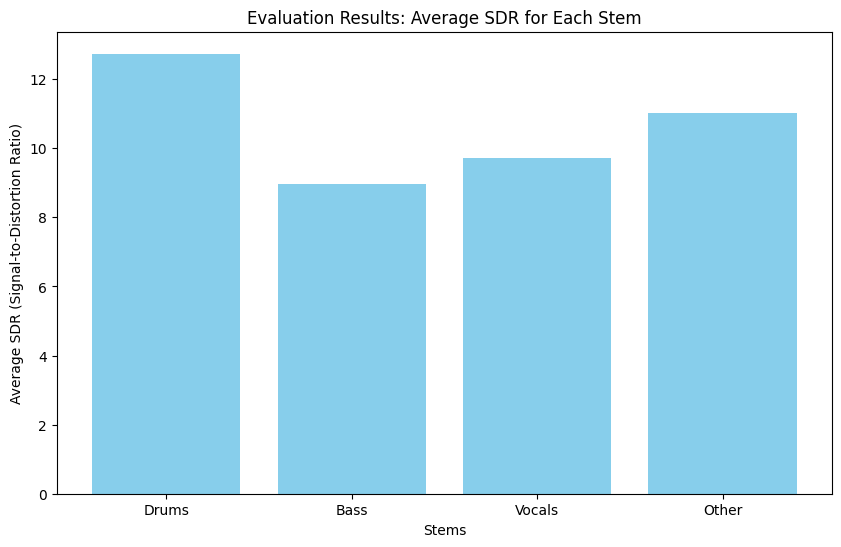

In [17]:
#Tempo d'esecuzione su Mac di Filippo: 1:59 s
uniform_gain = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device)

# Run the SDR evaluation
sdr_results = evaluate_sdr(dataset_dict, uniform_gain, model, device, sample_rate, segment_length=30)

# compute average SDR for each stem
sdr_averages = {
    "Drums": torch.tensor([v["drums"] for v in sdr_results.values() if v["drums"] is not None]).mean(),
    "Bass": torch.tensor([v["bass"] for v in sdr_results.values() if v["bass"] is not None]).mean(),
    "Vocals": torch.tensor([v["vocals"] for v in sdr_results.values() if v["vocals"] is not None]).mean(),
    "Other": torch.tensor([v["other"] for v in sdr_results.values() if v["other"] is not None]).mean()
}

# Plot the results
plt.figure(figsize=(10, 6))
stems_to_plot = list(sdr_averages.keys())
plt.bar(stems_to_plot, [sdr_averages[s] for s in stems_to_plot], color='skyblue')
plt.xlabel('Stems')
plt.ylabel('Average SDR (Signal-to-Distortion Ratio)')
plt.title('Evaluation Results: Average SDR for Each Stem')
plt.show()


Evaluating SDR:   0%|          | 0/34 [00:00<?, ?it/s]/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_45537/3514408379.py:71: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr = separation.bss_eval_sources(
Evaluating SDR: 100%|██████████| 34/34 [05:29<00:00,  9.68s/it]


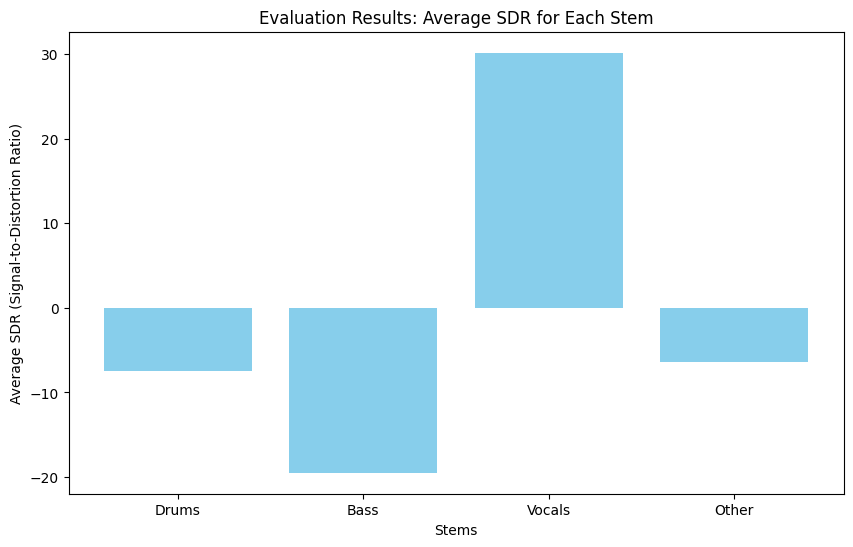

In [ ]:
#Tempo d'esecuzione su Mac di Filippo: 5:30 s

biased_gains = torch.tensor([0.01, 0.01, 0.97, 0.01], device=device)

# Run the SDR evaluation
# Move the model to CPU for operations requiring unsupported MPS operators
#model_cpu = model.to("cpu")

# Run the SDR evaluation on CPU
sdr_results = evaluate_sdr(dataset_dict, biased_gains, model, device, sample_rate, segment_length=30)

# Move the model back to the original device (MPS)
model.to(device)

# compute average SDR for each stem
sdr_averages = {
    "Drums": torch.tensor([v["drums"] for v in sdr_results.values() if v["drums"] is not None]).mean(),
    "Bass": torch.tensor([v["bass"] for v in sdr_results.values() if v["bass"] is not None]).mean(),
    "Vocals": torch.tensor([v["vocals"] for v in sdr_results.values() if v["vocals"] is not None]).mean(),
    "Other": torch.tensor([v["other"] for v in sdr_results.values() if v["other"] is not None]).mean()
}

# Plot the results
plt.figure(figsize=(10, 6))
stems_to_plot = list(sdr_averages.keys())
plt.bar(stems_to_plot, [sdr_averages[s] for s in stems_to_plot], color='skyblue')
plt.xlabel('Stems')
plt.ylabel('Average SDR (Signal-to-Distortion Ratio)')
plt.title('Evaluation Results: Average SDR for Each Stem')
plt.show()

In [ ]:
def evaluate_sdr_with_dynamic_gains(dataset_dict, initial_gains, model, device, sample_rate, segment_length=30, energy_threshold=1e-4, steps=10, target_stem="vocals"):
    """
    Evaluate SDR with dynamic gain modification for a specific target stem.

    Parameters:
        dataset_dict (dict): Dataset containing tracks and stems.
        initial_gains (torch.Tensor): Initial gains for the stems (e.g., [0.25, 0.25, 0.25, 0.25]).
        model (torch.nn.Module): Separation model.
        device (str): Device to run the evaluation on.
        sample_rate (int): Sample rate of the audio.
        segment_length (int): Length of the audio segments in seconds.
        energy_threshold (float): Threshold to skip low-energy stems.
        steps (int): Number of steps to modify the gains.
        target_stem (str): The name of the stem to apply the target gain (e.g., "vocals").

    Returns:
        dict: SDR results for each track and gain configuration.
    """
    # Map stem names to indices
    stem_indices = {"drums": 0, "bass": 1, "vocals": 2, "other": 3}
    if target_stem not in stem_indices:
        raise ValueError(f"Invalid target stem '{target_stem}'. Must be one of {list(stem_indices.keys())}.")
    target_stem_idx = stem_indices[target_stem]

    # Find non-silent segments for each track
    non_silent_dataset_dict = {}
    for track, stems in dataset_dict.items():
        non_silent_segment = find_non_silent_segment(stems, segment_seconds=segment_length, sample_rate=sample_rate)
        if non_silent_segment is not None:
            non_silent_dataset_dict[track] = non_silent_segment 

    sdr_results = {}

    for track in tqdm.tqdm(non_silent_dataset_dict, desc=f"Evaluating SDR with Dynamic Gains for '{target_stem}'"):
        if track not in non_silent_dataset_dict:
            print(f"Track '{track}' not found in dataset_dict. Skipping...")
            continue

        # Retrieve the original stems
        stems = non_silent_dataset_dict[track]
        if any(stem not in stems for stem in ["drums", "bass", "vocals", "other"]):
            print(f"Track '{track}' is missing some stems. Skipping...")
            continue

        print(f"\nEvaluating SDR for track '{track}' with dynamic gains for '{target_stem}'...")
        
        for step in range(steps + 1):
            # Increase the gain of the target stem and decrease others proportionally
            target_gain = initial_gains[target_stem_idx] + (step * 0.05)  # Increment target stem gain
            remaining_gain = 1.0 - target_gain  # Remaining gain to distribute
            other_gains = [
                (remaining_gain * (initial_gains[i] / (1.0 - initial_gains[target_stem_idx])))
                if i != target_stem_idx else target_gain
                for i in range(4)
            ]
            modified_gains = torch.tensor(other_gains, device=device)

            # Create a new mixture with modified gains
            new_mix = create_new_mixture(track, modified_gains, non_silent_dataset_dict)

            # Normalize the mixture
            mixture_norm, ref = normalize_waveform(new_mix, device)

            # Ci vuole: Assicurati che il tensore di input sia un torch.FloatTensor
            mixture_norm = mixture_norm.to(torch.float32)  # Converte il tensore di input a torch.FloatTensor

            # Ci vuole: Assicurati che il tensore sia sul dispositivo corretto (CPU o GPU)
            mixture_norm = mixture_norm.to(device)  # device dovrebbe essere 'cpu' o 'MPS' (a seconda della configurazione)

            # Ci vuole: Per i pesi del modello, assicurati che siano dello stesso tipo e dispositivo
            for param in model.parameters():
                param.data = param.data.to(torch.float32).to(device)

            # Ora chiamiamo la funzione separate_sources con i tensori e i pesi corretti
            sources_tensor = separate_sources(
                model,
                mixture_norm[None],  # Aggiungi la dimensione del batch
                segment=segment_length,
                overlap=0.0,        #Se non aggiungiamo i "Ci vuole:" non funziiona la funzione se si richiama più volte perché non si resetta il tensore
                device=device
            )[0]  # Rimuovi la dimensione del batch

            # Undo normalization
            sources_tensor = invert_normalization(sources_tensor, ref)

            # Map predicted sources to their names
            predicted_stems = dict(zip(model.sources, list(sources_tensor)))

            # Evaluate SDR for the target stem
            ref_stem = stems[target_stem].to(device)
            pred_stem = predicted_stems[target_stem]

            # Skip evaluation if energy is below the threshold
            energy = ref_stem.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                print(f"Skipping evaluation for '{track}' - '{target_stem}' due to low energy.")
                continue

            # Compute SDR
            try:
                sdr = separation.bss_eval_sources(
                    reference_sources=ref_stem.cpu().numpy(),
                    estimated_sources=pred_stem.cpu().numpy()
                )[0].mean()
                print(f"SDR with gains {modified_gains.tolist()}: {sdr:.2f}")
            except Exception as e:
                print(f"Error computing SDR for track '{track}' with gains {modified_gains.tolist()}: {e}")

    return sdr_results

In [22]:
#Tempo d'esecuzione su Mac di Filippo: 
initial_gains = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device)

# Run the SDR evaluation
# Move the model to CPU for operations requiring unsupported MPS operators
model_cpu = model.to("cpu")

# Run the SDR evaluation on CPU
sdr_results = evaluate_sdr_with_dynamic_gains(dataset_dict, initial_gains, model, device, sample_rate, 
                                              segment_length=30, steps=10, target_stem="vocals")

# Move the model back to the original device (MPS)
model.to(device)

# compute average SDR for each stem
sdr_averages = {
    "Drums": torch.tensor([v["drums"] for v in sdr_results.values() if v["drums"] is not None]).mean(),
    "Bass": torch.tensor([v["bass"] for v in sdr_results.values() if v["bass"] is not None]).mean(),
    "Vocals": torch.tensor([v["vocals"] for v in sdr_results.values() if v["vocals"] is not None]).mean(),
    "Other": torch.tensor([v["other"] for v in sdr_results.values() if v["other"] is not None]).mean()
}

# Plot the results
# plt.figure(figsize=(10, 6))
# stems_to_plot = list(sdr_averages.keys())
# plt.bar(stems_to_plot, [sdr_averages[s] for s in stems_to_plot], color='skyblue')
# plt.xlabel('Stems')
# plt.ylabel('Average SDR (Signal-to-Distortion Ratio)')
# plt.title('Evaluation Results: Average SDR for Each Stem')
# plt.show()

Evaluating SDR with Dynamic Gains for 'vocals':   0%|          | 0/34 [00:00<?, ?it/s]


Evaluating SDR for track 'AM Contra - Heart Peripheral' with dynamic gains for 'vocals'...


/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_45537/3159702984.py:101: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr = separation.bss_eval_sources(


SDR with gains [0.25, 0.25, 0.25, 0.25]: 16.84
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 17.90
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 18.86
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 19.89
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 20.97
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 22.03
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 23.08
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 24.15
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.6499999761581421, 0.11666667461395264]: 25.25
SDR with gains [0.10000000894069672, 0.10000000894069672, 0.699999988079071, 0.10000000894069672]: 26.40


Evaluating SDR with Dynamic Gains for 'vocals':   3%|▎         | 1/34 [00:36<20:04, 36.50s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 27.64

Evaluating SDR for track 'Al James - Schoolboy Facination' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 10.31
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 11.79
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 13.11
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 14.33
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 15.52
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 16.73
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 17.87
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 18.95
SDR with gains [0.11666667461395264, 0.11666

Evaluating SDR with Dynamic Gains for 'vocals':   6%|▌         | 2/34 [01:11<19:08, 35.88s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 23.05

Evaluating SDR for track 'Angels In Amplifiers - I'm Alright' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 12.53
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 13.97
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 15.26
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 16.45
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 17.58
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 18.65
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 19.71
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 20.81
SDR with gains [0.11666667461395264, 0.11

Evaluating SDR with Dynamic Gains for 'vocals':   9%|▉         | 3/34 [01:46<18:09, 35.13s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 24.69

Evaluating SDR for track 'Arise - Run Run Run' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 12.47
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 14.02
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 15.35
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 16.57
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 17.75
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 18.95
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 20.14
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 21.33
SDR with gains [0.11666667461395264, 0.11666667461395264

Evaluating SDR with Dynamic Gains for 'vocals':  12%|█▏        | 4/34 [02:20<17:24, 34.82s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 25.26

Evaluating SDR for track 'BKS - Bulldozer' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 16.63
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 17.66
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 18.57
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 19.44
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 20.28
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 21.11
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 21.92
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 22.71
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.

Evaluating SDR with Dynamic Gains for 'vocals':  15%|█▍        | 5/34 [02:54<16:41, 34.53s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 24.87

Evaluating SDR for track 'BKS - Too Much' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 16.27
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 17.68
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 18.96
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 20.15
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 21.29
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 22.41
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 23.52
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 24.65
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.6

Evaluating SDR with Dynamic Gains for 'vocals':  18%|█▊        | 6/34 [03:28<15:58, 34.22s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 28.45

Evaluating SDR for track 'Ben Carrigan - We'll Talk About It All Tonight' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 9.42
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 11.09
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 12.48
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 13.71
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 14.84
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 15.85
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 16.78
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 17.68
SDR with gains [0.116666674613

Evaluating SDR with Dynamic Gains for 'vocals':  21%|██        | 7/34 [04:03<15:32, 34.52s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 20.42

Evaluating SDR for track 'Bobby Nobody - Stitch Up' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 10.45
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 11.70
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 12.86
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 13.99
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 15.14
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 16.31
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 17.49
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 18.66
SDR with gains [0.11666667461395264, 0.116666674613

Evaluating SDR with Dynamic Gains for 'vocals':  24%|██▎       | 8/34 [04:37<14:57, 34.51s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 22.65

Evaluating SDR for track 'Carlos Gonzalez - A Place For Us' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 14.64
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 16.01
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 17.26
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 18.48
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 19.69
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 20.90
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 22.11
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 23.32
SDR with gains [0.11666667461395264, 0.1166

Evaluating SDR with Dynamic Gains for 'vocals':  26%|██▋       | 9/34 [05:13<14:28, 34.73s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 27.20

Evaluating SDR for track 'Hollow Ground - Ill Fate' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 6.27
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 7.83
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 9.23
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 10.56
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 11.87
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 13.17
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 14.48
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 15.84
SDR with gains [0.11666667461395264, 0.116666674613952

Evaluating SDR with Dynamic Gains for 'vocals':  29%|██▉       | 10/34 [05:47<13:53, 34.72s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 20.54

Evaluating SDR for track 'Juliet's Rescue - Heartbeats' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 13.84
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 15.07
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 16.19
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 17.25
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 18.27
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 19.29
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 20.33
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 21.42
SDR with gains [0.11666667461395264, 0.11666667

Evaluating SDR with Dynamic Gains for 'vocals':  32%|███▏      | 11/34 [06:22<13:18, 34.72s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 25.19

Evaluating SDR for track 'Little Chicago's Finest - My Own' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 13.65
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 14.93
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 16.10
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 17.18
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 18.21
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 19.23
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 20.25
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 21.32
SDR with gains [0.11666667461395264, 0.1166

Evaluating SDR with Dynamic Gains for 'vocals':  35%|███▌      | 12/34 [06:58<12:53, 35.14s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 25.02

Evaluating SDR for track 'M.E.R.C. Music - Knockout' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 7.26
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 8.66
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 10.03
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 11.38
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 12.65
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 13.89
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 15.14
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 16.41
SDR with gains [0.11666667461395264, 0.1166666746139

Evaluating SDR with Dynamic Gains for 'vocals':  38%|███▊      | 13/34 [07:33<12:15, 35.03s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 20.50

Evaluating SDR for track 'Moosmusic - Big Dummy Shake' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 13.31
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 13.87
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 14.39
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 14.91
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 15.46
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 16.01
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 16.44
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 17.01
SDR with gains [0.11666667461395264, 0.116666674

Evaluating SDR with Dynamic Gains for 'vocals':  41%|████      | 14/34 [08:07<11:37, 34.87s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 18.99

Evaluating SDR for track 'Motor Tapes - Shore' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 8.54
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 10.15
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 11.55
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 12.82
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 14.01
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 15.15
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 16.27
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 17.41
SDR with gains [0.11666667461395264, 0.11666667461395264,

Evaluating SDR with Dynamic Gains for 'vocals':  44%|████▍     | 15/34 [08:42<11:01, 34.81s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 21.30

Evaluating SDR for track 'Mu - Too Bright' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 13.66
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 15.07
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 16.35
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 17.54
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 18.65
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 19.74
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 20.84
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 21.97
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.

Evaluating SDR with Dynamic Gains for 'vocals':  47%|████▋     | 16/34 [09:18<10:30, 35.05s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 25.78

Evaluating SDR for track 'Nerve 9 - Pray For The Rain' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 13.70
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 15.26
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 16.63
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 17.87
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 19.04
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 20.19
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 21.35
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 22.50
SDR with gains [0.11666667461395264, 0.116666674

Evaluating SDR with Dynamic Gains for 'vocals':  50%|█████     | 17/34 [09:53<09:59, 35.26s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 26.19

Evaluating SDR for track 'PR - Happy Daze' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: -8.94
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: -9.65
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: -10.57
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: -11.78
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: -13.47
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: -16.01
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: -20.01
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: -22.31
SDR with gains [0.11666667461395264, 0.116666674613952

Evaluating SDR with Dynamic Gains for 'vocals':  53%|█████▎    | 18/34 [10:29<09:24, 35.27s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: -6.36

Evaluating SDR for track 'PR - Oh No' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 6.20
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 7.89
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 9.03
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 10.06
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 11.11
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 12.16
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 12.88
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 12.68
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.64999997

Evaluating SDR with Dynamic Gains for 'vocals':  56%|█████▌    | 19/34 [11:04<08:49, 35.30s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 6.69

Evaluating SDR for track 'Punkdisco - Oral Hygiene' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 8.33
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 10.16
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 11.74
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 13.18
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 14.57
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 15.90
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 17.18
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 18.46
SDR with gains [0.11666667461395264, 0.11666667461395

Evaluating SDR with Dynamic Gains for 'vocals':  59%|█████▉    | 20/34 [11:40<08:17, 35.55s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 22.54

Evaluating SDR for track 'Raft Monk - Tiring' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 5.96
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 7.50
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 8.89
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 10.21
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 11.48
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 12.72
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 13.97
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 15.26
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.

Evaluating SDR with Dynamic Gains for 'vocals':  62%|██████▏   | 21/34 [12:15<07:39, 35.38s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 19.67

Evaluating SDR for track 'Secretariat - Borderline' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 5.69
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 7.21
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 8.60
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 9.92
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 11.15
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 12.28
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 13.41
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 14.62
SDR with gains [0.11666667461395264, 0.1166666746139526

Evaluating SDR with Dynamic Gains for 'vocals':  65%|██████▍   | 22/34 [12:51<07:05, 35.43s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 18.98

Evaluating SDR for track 'Secretariat - Over The Top' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 11.34
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 12.48
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 13.54
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 14.58
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 15.62
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 16.67
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 17.73
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 18.79
SDR with gains [0.11666667461395264, 0.1166666746

Evaluating SDR with Dynamic Gains for 'vocals':  68%|██████▊   | 23/34 [13:24<06:23, 34.88s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 22.59

Evaluating SDR for track 'Side Effects Project - Sing With Me' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 14.04
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 15.44
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 16.71
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 17.91
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 19.05
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 20.20
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 21.37
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 22.57
SDR with gains [0.11666667461395264, 0.1

Evaluating SDR with Dynamic Gains for 'vocals':  71%|███████   | 24/34 [13:59<05:48, 34.82s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 26.68

Evaluating SDR for track 'Signe Jakobsen - What Have You Done To Me' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 14.87
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 16.14
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 17.24
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 18.28
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 19.28
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 20.26
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 21.28
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 22.36
SDR with gains [0.1166666746139526

Evaluating SDR with Dynamic Gains for 'vocals':  74%|███████▎  | 25/34 [14:34<05:13, 34.81s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 25.44

Evaluating SDR for track 'Skelpolu - Resurrection' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: -19.83
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: -19.83
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: -19.82
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: -19.82
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: -19.82
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: -19.81
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: -19.80
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: -19.79
SDR with gains [0.11666667461395264, 0.11666

Evaluating SDR with Dynamic Gains for 'vocals':  76%|███████▋  | 26/34 [15:09<04:39, 34.97s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: -19.75

Evaluating SDR for track 'The Doppler Shift - Atrophy' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 29.81
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 30.38
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 31.00
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 31.66
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 32.38
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 33.18
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 34.06
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 35.05
SDR with gains [0.11666667461395264, 0.11666667

Evaluating SDR with Dynamic Gains for 'vocals':  79%|███████▉  | 27/34 [15:44<04:04, 34.94s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 39.01

Evaluating SDR for track 'The Easton Ellises (Baumi) - SDRNR' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: -2.02
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: -1.58
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: -1.10
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: -0.57
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 0.01
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 0.67
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 1.41
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 2.26
SDR with gains [0.11666667461395264, 0.116666

Evaluating SDR with Dynamic Gains for 'vocals':  82%|████████▏ | 28/34 [16:18<03:28, 34.71s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 5.81

Evaluating SDR for track 'The Easton Ellises - Falcon 69' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 8.15
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 9.71
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 11.03
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 12.24
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 13.38
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 14.52
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 15.69
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 16.91
SDR with gains [0.11666667461395264, 0.116666674

Evaluating SDR with Dynamic Gains for 'vocals':  85%|████████▌ | 29/34 [16:52<02:52, 34.52s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 20.86

Evaluating SDR for track 'The Sunshine Garcia Band - For I Am The Moon' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 9.63
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 10.86
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 12.03
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 13.15
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 14.23
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 15.31
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 16.43
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 17.61
SDR with gains [0.11666667461395

Evaluating SDR with Dynamic Gains for 'vocals':  88%|████████▊ | 30/34 [17:26<02:17, 34.28s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 21.90

Evaluating SDR for track 'Timboz - Pony' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 4.50
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 5.88
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 7.11
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 8.26
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 9.37
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 10.47
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 11.58
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 12.76
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.6499999

Evaluating SDR with Dynamic Gains for 'vocals':  91%|█████████ | 31/34 [18:01<01:43, 34.50s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 16.88

Evaluating SDR for track 'Triviul feat. The Fiend - Widow' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 13.33
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 14.66
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 15.84
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 16.91
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 17.95
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 18.97
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 20.00
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 21.05
SDR with gains [0.11666667461395264, 0.11666

Evaluating SDR with Dynamic Gains for 'vocals':  94%|█████████▍| 32/34 [18:35<01:08, 34.46s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 24.84

Evaluating SDR for track 'We Fell From The Sky - Not You' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 8.36
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 9.42
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 10.44
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 11.42
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 12.37
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 13.28
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 14.19
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 15.16
SDR with gains [0.11666667461395264, 0.11666667

Evaluating SDR with Dynamic Gains for 'vocals':  97%|█████████▋| 33/34 [19:10<00:34, 34.42s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 18.62

Evaluating SDR for track 'Zeno - Signs' with dynamic gains for 'vocals'...
SDR with gains [0.25, 0.25, 0.25, 0.25]: 11.24
SDR with gains [0.23333333432674408, 0.23333333432674408, 0.30000001192092896, 0.23333333432674408]: 12.54
SDR with gains [0.21666666865348816, 0.21666666865348816, 0.3499999940395355, 0.21666666865348816]: 13.69
SDR with gains [0.20000001788139343, 0.20000001788139343, 0.4000000059604645, 0.20000001788139343]: 14.79
SDR with gains [0.18333333730697632, 0.18333333730697632, 0.44999998807907104, 0.18333333730697632]: 15.85
SDR with gains [0.1666666716337204, 0.1666666716337204, 0.5, 0.1666666716337204]: 16.90
SDR with gains [0.15000000596046448, 0.15000000596046448, 0.550000011920929, 0.15000000596046448]: 18.01
SDR with gains [0.13333332538604736, 0.13333332538604736, 0.6000000238418579, 0.13333332538604736]: 19.10
SDR with gains [0.11666667461395264, 0.11666667461395264, 0.649

Evaluating SDR with Dynamic Gains for 'vocals': 100%|██████████| 34/34 [19:44<00:00, 34.84s/it]

SDR with gains [0.0833333358168602, 0.0833333358168602, 0.75, 0.0833333358168602]: 22.57
